In [19]:
import numpy as np
import matplotlib.pyplot as plt
import gaussproc as gp
from scipy.linalg import solve

In [20]:
bounds = np.array([0.0, np.pi/2])

noise = 0.1

num_datapoints = 10
datagrid = np.linspace(*bounds,num_datapoints)

num_gridpoints = 101
grid = np.linspace(*bounds,num_gridpoints)

In [21]:
def func(x):
    return np.cos(2*x)

# def func(x):
#     return np.sin(x)

def grad_func(x,noise=0.0):
    return -2*np.sin(2*x) + noise*np.random.randn(*x.shape)

# def grad_func(x,noise=0.0):
#     return np.cos(x) + noise*np.random.randn(*x.shape)

In [22]:
from scipy.special import erf

def Phi(x):
    return np.sqrt(np.pi)/2*erf(x)

def integrated_kernel(point,bounds,param=1.0):
    upperbound = (bounds[1] - point) / (np.sqrt(2) * param)
    lowerbound = (bounds[0] - point) / (np.sqrt(2) * param)
    return np.sqrt(2) * param * (Phi(upperbound) - Phi(lowerbound))

def doubleintegrate_kernel(bounds,param=1.0):
    value = (bounds[1] - bounds[0]) / (np.sqrt(2)*param**2)
    return 2 * (bounds[1] - bounds[0]) * Phi(value) + np.sqrt(2) * param * (np.exp(-value**2) - 1)
    # return 2 * np.sqrt(2) * param * (bounds[1] - bounds[0]) * Phi(value) + 4 * param**2 * (np.exp(-value**2) - 1)

In [23]:
data_vector = grad_func(datagrid,noise)
cov_mat = gp.cov_matrix(datagrid,alpha=noise**2)
temp = solve(cov_mat,data_vector)
means = np.array([gp.gausskernel(x,datagrid)@temp for x in grid])
vars = np.array([gp.gausskernel(x,x) - gp.gausskernel(x,datagrid)@solve(cov_mat,gp.gausskernel(x,datagrid)) for x in grid])
stds = np.sqrt(np.abs(vars))

In [24]:
mean_integral = np.zeros_like(grid)
integral_1 = np.zeros_like(grid)
integral_2 = np.zeros_like(grid)
integral_3 = np.zeros_like(grid)

for i,point in enumerate(grid[1:]):
    bound = np.array([0,point])
    integral_vector = integrated_kernel(datagrid,bound)
    mean_integral[i+1] = integral_vector@temp
    temp2 = solve(cov_mat,integral_vector)
    integral_1[i+1] = doubleintegrate_kernel(bound)
    integral_2[i+1] = (bound[1]-bound[0])
    integral_3[i+1] = integral_vector@temp2

integral_vector = integrated_kernel(datagrid,bounds)
integral = integral_vector@temp

print(integral)

# std_integral = np.sqrt(np.abs(var_integral))

-1.875263817258869


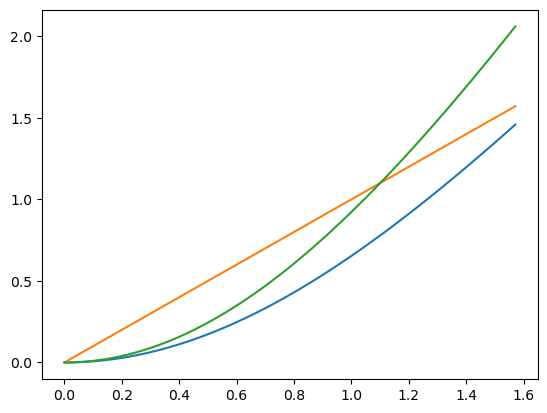

In [25]:
plt.plot(grid,integral_1)
plt.plot(grid,integral_2)
plt.plot(grid,integral_3)
# plt.plot(grid,integral_1-integral_3)

std_integral = np.sqrt(np.abs(integral_1-integral_3))

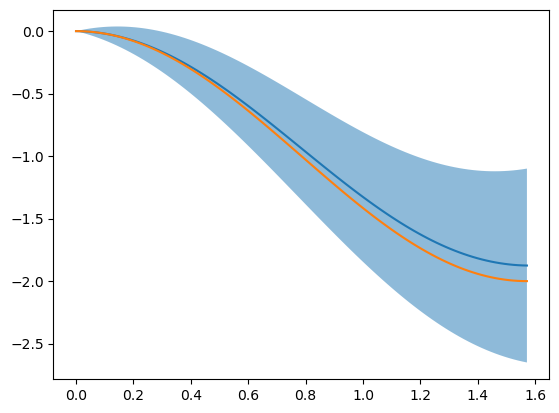

In [26]:
plt.plot(grid,mean_integral)
plt.fill_between(grid,mean_integral-std_integral,mean_integral+std_integral,alpha=0.5)
plt.plot(grid,func(grid)-1)

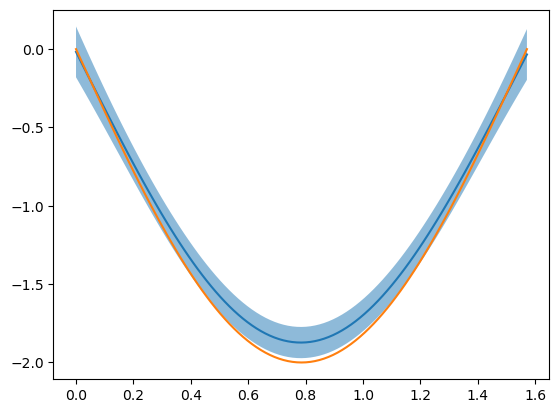

In [27]:
plt.plot(grid,means)
plt.fill_between(grid,means-2*stds,means+2*stds,alpha=0.5)
plt.plot(grid,grad_func(grid))